# Notebook Description
In this notebook I implement the `IP2Vec` model ([Ring et al. (2017)](https://ieeexplore.ieee.org/document/8215725)). In `IP2Vec`, the researchers aim to embed IP addresses in numeric vectors, using a method that builds on ideas from `Word2Vec` ([Mikolov et al. (2013a)](https://arxiv.org/abs/1301.3781)). Their key idea is to learn similarities by extracting available context information from network data, and by looking at traffic flows between IP addresses, ports, and protocols. Looking at temporal information allows them to convert such movements in networks into sequences, and apply similar methods to them. Just like in `Word2Vec`, two IP addresses will be considered close if they appear in similar contexts.  

To test their results, I will be using the CIC-Darknet2020 Internet Traffic data from [here](https://www.kaggle.com/datasets/peterfriedrich1/cicdarknet2020-internet-traffic).  

Most of the online resources that discuss `Word2Vec` describes it as just an `Embedding Layer` that is optimized via `Cross Entropy`. Unfortunately, it is more complex than that. Using the naive approach that was suggested in their original paper will lead to inefficient updation.  

Since every sentence has a limited number of words, each sentence produces only a handful of meaningful gradients. Consequentially, updating all the weights leads to sparse updation and a very slow training time.  

![Word2Vec Observations Generation, source: [Mikolov et al. (2013)](https://arxiv.org/abs/1301.3781)](https://i0.wp.com/datascientest.com/wp-content/uploads/2020/09/Capture-de%CC%81cran-2020-09-18-a%CC%80-09.27.50.png?w=842&ssl=1)

In order to avoid such issues, the original paper was accompanied by another paper that surveyed different training methods for the then-considered-large model. In [Mikolov et al. (2013b)](https://arxiv.org/pdf/1310.4546.pdf)) the original writers of `Word2Vec` introduce a few methods and tricks that allowed them to train `Word2Vec`. One method involves changing the loss function into a tree-based one, called *hierarchical softmax*. Another approach involves creating artificial sequences of words and training the network in a contrastive fashion, where the model learns to tell the true cases from the false ones. This method allows us to convert the costly `Cross Entropy` loss into a `Binary Cross Entropy` loss. It is called *negative sampling*, describing how to draw examples out of the empirical distribution of words to increase generalizability and avoid overfitting. A more thorough explenation of *negative sampling* can be found [here](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/).  

In this notebook I implement `IP2Vec` using negative sampling.

### The notebook is organized as follows:
1. Load the public dataset and process it.
2. Create the suplimentary tables for using Negative Sampling
3. Create the model using `pytorch`
4. Train.

# 0. Setup

In [1]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

import torch as th
from torch.autograd import Variable as V
from torch import nn,optim
import numpy as np
import random

pd.set_option('display.max_columns', None)

%load_ext google.colab.data_table
from google.colab import data_table
from google.colab import drive

drive.mount('/content/drive/')
# os.chdir("Your Location here")

import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_folder = './data/'

Mounted at /content/drive/
cuda


# 1. Preprocessing

## 1.a. Load and Preprocess Data

In [3]:
df = pd.read_csv(data_folder + 'Darknet.CSV', on_bad_lines='skip')

print(df.shape)

df.iloc[:5]

(141530, 85)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24/07/2015 04:09:48 PM,229,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,8733.624454,229.000000,0.000000,229,229,0,0.000000,0.000000,0,0,0,0.000000,0.00000,0,0,0,0,0,0,20,20,4366.812227,4366.812227,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1892,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24/07/2015 04:09:48 PM,407,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4914.004914,407.000000,0.000000,407,407,0,0.000000,0.000000,0,0,0,0.000000,0.00000,0,0,0,0,0,0,20,20,2457.002457,2457.002457,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1987,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24/07/2015 04:09:48 PM,431,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4640.371230,431.000000,0.000000,431,431,0,0.000000,0.000000,0,0,0,0.000000,0.00000,0,0,0,0,0,0,20,20,2320.185615,2320.185615,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2049,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24/07/2015 04:09:48 PM,359,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,5571.030641,359.000000,0.000000,359,359,0,0.000000,0.000000,0,0,0,0.000000,0.00000,0,0,0,0,0,0,20,20,2785.515320,2785.515320,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2008,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,64530,6659,131,0,109.187817,22.283313,498,0,16.6475,46.833714,6604.75239,91.942711,10887.324242,11412.466412,78158,13,10778451,18268.561017,11786.143089,81171,126,10747836,26936.932331,15897.73845,78158,307,1,0,0,0,11820,8000,54.831627,37.111084,0,498,71.876008,56.93647,3241.761603,1,0,0,659,991,0,0,0,0,71.948537,109.187817,16.6475,0,0,0,0,659,6605,0,65,0,6,1382,2320,581,20,0,0,0,0,1.437765e+15,3.117718e+06,1.437765e+15,1.437765e+15,Non-Tor,AUDIO-STREAMING


In [4]:
print('Total Number of flows:',len(df['Flow ID'].unique()))
print('Obs per flow, 10 largets:\n', df['Flow ID'].value_counts().value_counts()[:10])

df['src-dst'] = df['Src IP']+'-'+df['Dst IP']
print('Number of unique flows per Flow ID:\n', df.groupby(['Flow ID'])['src-dst'].nunique().value_counts())

df['src-dst-dst port-protocol'] = df['Src IP']+'-'+df['Dst IP']+'-'+df['Dst Port'].astype(str)+'-'+df['Protocol'].astype(str)
print('Number of unique flow charactaristics per Flow ID:\n', df.groupby(['Flow ID'])['src-dst-dst port-protocol'].nunique().value_counts())

filtered_df = df[['Src IP', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp']].drop_duplicates()
filtered_df['Dst Port'] = filtered_df['Dst Port'].astype(str)
filtered_df['Protocol'] = filtered_df['Protocol'].astype(str)
filtered_df.iloc[:5]


Total Number of flows: 77568
Obs per flow, 10 largets:
 1     49363
2     17841
4      5995
3      1917
6       844
8       616
10      197
5       156
12      114
16       53
Name: Flow ID, dtype: int64
Number of unique flows per Flow ID:
 1    77568
Name: src-dst, dtype: int64
Number of unique flow charactaristics per Flow ID:
 1    77568
Name: src-dst-dst port-protocol, dtype: int64


,Src IP,Dst IP,Dst Port,Protocol,Timestamp
0,10.152.152.11,216.58.220.99,443,6,24/07/2015 04:09:48 PM
3,10.152.152.11,74.125.136.120,443,6,24/07/2015 04:09:48 PM
4,10.152.152.11,173.194.65.127,19305,6,24/07/2015 04:09:45 PM
5,10.152.152.11,173.194.65.127,443,6,24/07/2015 04:10:00 PM
6,173.194.33.97,10.152.152.11,56254,6,24/07/2015 04:09:45 PM


## 1.b. Create Utility Functions for Generation



In [5]:
def gen_sameples_and_vocab_from_a_flow(df, flatten=True, source_ip = 'Src IP', dest_ip = 'Dst IP', proto = 'Protocol', dest_port = 'Dst Port'):
    """
    Create pairs from a Flow dataset and vocabulary
    """
    df = df.reset_index(drop=True)
    pairs = [(
        (df[source_ip][j],df[dest_ip][j]), 
        (df[source_ip][j],df[dest_port][j]), 
        (df[source_ip][j],df[proto][j]), 
        (df[dest_port][j], df[dest_ip][j]),
        (df[proto][j], df[dest_ip][j])
     ) for j in range(len(df))]
    
    if flatten:
        pairs = [item for sublist in pairs for item in sublist]
    
    vocab = set(df[source_ip].tolist() + df[dest_ip].tolist() + df[dest_port].tolist() + df[proto].tolist())
    vocab_size = len(vocab)
    word_to_ind = {word:idx for idx,word in enumerate(vocab)}
    ind_to_word = {idx:word for idx,word in enumerate(vocab)}
    
    return pairs, vocab, vocab_size, word_to_ind, ind_to_word

pairs, vocab, vocab_size, word_to_ind, ind_to_word = gen_sameples_and_vocab_from_a_flow(filtered_df)

print(f'Vocabulary size: {vocab_size}')
print('First five elements:\n', list(vocab)[:5])
print('First five nested pairs:')
pairs[:10]



Vocabulary size: 20472
First five elements:
 ['27627', '23.36.90.113', '51947', '42788', '1797']
First five nested pairs:


[('10.152.152.11', '216.58.220.99'),
 ('10.152.152.11', '443'),
 ('10.152.152.11', '6'),
 ('443', '216.58.220.99'),
 ('6', '216.58.220.99'),
 ('10.152.152.11', '74.125.136.120'),
 ('10.152.152.11', '443'),
 ('10.152.152.11', '6'),
 ('443', '74.125.136.120'),
 ('6', '74.125.136.120')]

## 1.c. Negative Sampling
Most of the source code for this part was taken from [here](http://www.cse.chalmers.se/~richajo/nlp2019/l3/Skip-gram%20with%20negative%20sampling.html).  

  
Negative sampling in the context of `Word2Vec` means two major changes in the `Word2Vec` model:
1. Changing the model: Under negative sampling we change our "point of view" - before, we trained a model to find *which* words are the neighbors of a given word. Here, we ask *whether a word is a neighbor of our target word*. The change of question is also reflected by changing the stracture of the model. Before, we only trained one linear layer, for finding neighbors. Here, we train two linear layers, one for the target word and another for the context word(s), and multiply them using `dot`. This change also means that we can change the loss function from Cross Entropy, to Binary Cross Entropy.
2. Generate negative samples. Maybe the hardest part about the change. We do that so we can train our model to begin with. Using the first (naive) approach leads to inefficient updation. We update the whole netword even though we have only several number of neighbors for a given word. Therefore the change is very sparse each time, and we don't really need to update the whole model. Negative sampling allows us to update only `K+1` buttons each time. What is tricky is the way of generating negative samples. We start by doing that.


### `Ns` Table


In [6]:
corpus = pairs
voc_size = vocab_size

print(voc_size)
corpus[:5]

20472


[('10.152.152.11', '216.58.220.99'),
 ('10.152.152.11', '443'),
 ('10.152.152.11', '6'),
 ('443', '216.58.220.99'),
 ('6', '216.58.220.99')]

In [7]:
t = 60
power_parameter = 0.75
ns_table_size = 100000

def make_ns_table_ips(pairs, t=60, power_parameter=0.75, ns_table_size=100000):
  """
  pairs - pairs of entities. Probably (ip_source,ip_destination) in our real data.
  t - threshold variable from the paper.
  """
  from collections import Counter
  import operator

  flat_list_of_pairs = [item for sublist in pairs for item in sublist]
  counter = Counter(flat_list_of_pairs)

  # replace all the counts for cases where #.times of appearence < t --> 0
  increasingly_sorted_counter = dict(sorted(counter.items(), key=operator.itemgetter(1)))
  increasingly_sorted_counter_keys = list(increasingly_sorted_counter.keys())
  increasingly_sorted_counter_values = np.array(list(increasingly_sorted_counter.values()))
  increasingly_sorted_counter_values[increasingly_sorted_counter_values<t] = 0
  increasingly_sorted_counter_thresholded = {i : j for i, j in zip(increasingly_sorted_counter_keys, increasingly_sorted_counter_values)}
  decreasingly_sorted_counter_thresholded = dict(sorted(increasingly_sorted_counter_thresholded.items(), key=operator.itemgetter(1),reverse=True))

  # convert to frequencies rather than counts
  # S = np.sum(np.array(list(decreasingly_sorted_counter_thresholded.values())))
  S = 1
  decreasingly_sorted_counter_thresholded_freq_values = [decreasingly_sorted_counter_thresholded[k]/S for k in decreasingly_sorted_counter_thresholded.keys()]
  decreasingly_sorted_counter_thresholded_keys = list(decreasingly_sorted_counter_thresholded.keys())

  # Create negative_sampling table
  # The negative sampling probabilities are proportional to the frequencies
  # to the power of a constant (typically 0.75).
  freqs_sorted = [(decreasingly_sorted_counter_thresholded_keys[j], decreasingly_sorted_counter_thresholded_freq_values[j]) for j in range(len(decreasingly_sorted_counter_thresholded_keys))]
  ns_table = {}
  sum_freq = 0
  for w, freq in freqs_sorted:
      ns_freq = freq ** power_parameter
      ns_table[w] = ns_freq
      sum_freq += ns_freq

  # Convert the negative sampling probabilities to integers, in order to make
  # sampling a bit faster and easier.
  # We return a list of tuples consisting of:
  # - the word
  # - its frequency in the training data
  # - the number of positions reserved for this word in the negative sampling table
  scaler = ns_table_size / sum_freq
  results = [(w, freq, int(round(ns_table[w]*scaler))) for w, freq in freqs_sorted]
  return results



In [8]:
ns_table = make_ns_table_ips(pairs)

print('Sum:', np.sum([x[2] for x in ns_table]))
ns_table[:5]

Sum: 99901


[('10.152.152.11', 160497.0, 10787),
 ('6', 110630.0, 8160),
 ('17', 54310.0, 4786),
 ('53', 23346.0, 2541),
 ('443', 23026.0, 2514)]

## 1.d. Generating target–context pairs
The following class is used to go through the training file line by line, and generate positive training instances (pairs consisting of a target word and a context word). Here, we will use all the preprocessing intricacies described in [Mikolov](https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)'s paper.

The `batches` method will generate one batch at a time, containing a number of positive training instances coded as integers. The negative training instances will be created elsewhere.  

**Instead of continuing with the author's code, I branched out here. For some reason the author's code got broken here, so in order to generate examples, what I am doing is to create the actual table given from the previous part. Then, if one wants `k` examples, then he/she should draw `k` examples from that table.**  

- Note to self: Use some transformation to make the frequency distribution more uniform (maybe use `log` then multiply by a constant).



In [9]:
k = 6

unflattened_list = [[x[0]]*x[2] for x in ns_table]
flattened_list = np.array([item for sublist in unflattened_list for item in sublist])
false_entities = np.random.choice(flattened_list, size=k)


In [10]:
pairs_batch = pairs[:16]
pairs_batch

[('10.152.152.11', '216.58.220.99'),
 ('10.152.152.11', '443'),
 ('10.152.152.11', '6'),
 ('443', '216.58.220.99'),
 ('6', '216.58.220.99'),
 ('10.152.152.11', '74.125.136.120'),
 ('10.152.152.11', '443'),
 ('10.152.152.11', '6'),
 ('443', '74.125.136.120'),
 ('6', '74.125.136.120'),
 ('10.152.152.11', '173.194.65.127'),
 ('10.152.152.11', '19305'),
 ('10.152.152.11', '6'),
 ('19305', '173.194.65.127'),
 ('6', '173.194.65.127'),
 ('10.152.152.11', '173.194.65.127')]

In [11]:
class ContextGenerator:
  def __init__(self, ns_table, k=20):
    
    # Cerate a repeated list of negative samples, using ns_table
    unflattened_list = [[x[0]]*x[2] for x in ns_table]
    flattened_list = np.array([item for sublist in unflattened_list for item in sublist])
    self.ns_table = flattened_list
    self.k = k

  def create_batch(self, true_pairs):
    """
    Create a batch of examples to be entered later to the ip2vec model.
    - pairs_batch: a list of true pairs, containing pairs of entities like described in 
      the ip2vec paper [(ip1,ip2)(ip1,destination_protocol2),...].
    - ns_table: A list of different entities from the data, with their empirical
      probabilities, and with the number of times they are to repeat in the table
      that we will train on.
    
    stages:
    1. Given desired number of examples:
      - Sample alpha in [1, int(theta*<batch_size>)] to make the number of true 
        pairs in the batch. The rest of the sample [int(0.25*<batch_size>), (<batch_size>-1)] 
        will be the false pairs to be generated.
      - Draw <alpha> number of obs from pairs
      - Draw (<batch_size>-<alpha>) ip addresses from ns_table.
      - Choose with replacement ip addresses from the true pairs and assign them with
        new destinations.
    
    """

    # unpack from self
    ns_table = self.ns_table
    k = self.k
    batch_size = len(true_pairs)
    
    # define resulting_batch
    resulting_batch = []

    # add positive pairs to batch
    for pair in true_pairs:
      resulting_batch.append([pair[0],pair[1], 1])

    # keep only sources
    sources = [x[0] for x in true_pairs]
    
    # Draw batch_size-alpha false entities
    false_entities = np.random.choice(flattened_list, size=(k*batch_size))
    
    # add negative pairs to batch
    for j in range(len(false_entities)):
      resulting_batch.append([np.random.choice(sources), false_entities[j], 0])

    return np.array(resulting_batch)
  
  

In [12]:
context_generator = ContextGenerator(ns_table=ns_table)
context_generator.create_batch(true_pairs=pairs[:5])


array([['10.152.152.11', '216.58.220.99', '1'],
       ['10.152.152.11', '443', '1'],
       ['10.152.152.11', '6', '1'],
       ['443', '216.58.220.99', '1'],
       ['6', '216.58.220.99', '1'],
       ['10.152.152.11', '54527', '0'],
       ['10.152.152.11', '6', '0'],
       ['10.152.152.11', '131.202.240.150', '0'],
       ['6', '10000', '0'],
       ['10.152.152.11', '72.21.81.253', '0'],
       ['6', '201.102.63.143', '0'],
       ['10.152.152.11', '17500', '0'],
       ['6', '53', '0'],
       ['10.152.152.11', '173.194.65.155', '0'],
       ['10.152.152.11', '131.202.6.3', '0'],
       ['10.152.152.11', '121.215.39.106', '0'],
       ['10.152.152.11', '54303', '0'],
       ['6', '17', '0'],
       ['10.152.152.11', '5.39.84.13', '0'],
       ['443', '19302', '0'],
       ['443', '173.194.112.109', '0'],
       ['6', '51.255.15.132', '0'],
       ['10.152.152.11', '131.202.243.255', '0'],
       ['10.152.152.11', '131.202.244.5', '0'],
       ['443', '216.58.216.66', '0'],
     

In [13]:
batch = context_generator.create_batch(true_pairs=pairs[:5])
batch[:,2]

array(['1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0'], dtype='<U21')

In [14]:
batch[:,2].astype(int)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
class IP2Vec(nn.Module):
  def __init__(self, vocab_size, word_to_ind, embedding_dim=128):
    super().__init__()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.device = device
    self.word_to_ind = word_to_ind
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.u_embedding = nn.Embedding(vocab_size,embedding_dim)
    self.v_embedding = nn.Embedding(vocab_size,embedding_dim)
    self.log_sigmoid = nn.LogSigmoid()
    
    init_range= 0.5/embedding_dim
    self.u_embedding.weight.data.uniform_(-init_range,init_range)
    self.v_embedding.weight.data.uniform_(-0,0)
        
    # Target word embeddings
    self.w = nn.Embedding(voc_size, embedding_dim)
    # Context embeddings
    self.c = nn.Embedding(voc_size, embedding_dim)
    
  def get_ip_embeddings(self,ip):
    ip = torch.tensor([word_to_ind[ip]])
    ip = ip.to(self.device)
    return self.u_embedding(ip).view(1,-1)

  def forward(self, targets, contexts): # target, context,neg
    # batch looks like the following:
    #   array([[a,b,1],
    #          [c,d,1],
    #          [c,m,0],
    #          [c,g,0]])

    
    # Look up the embeddings for the target words.
    # shape: (batch size, embedding dimension)
    tagets_embeddings = self.u_embedding(targets)
    n_batch, _ = tagets_embeddings.shape

    # View this as a 3-dimensional tensor, with
    # shape (batch size, 1, embedding dimension)
    tagets_embeddings = tagets_embeddings.view(n_batch, 1, self.embedding_dim)

    # Look up the embeddings for the positive and negative context words.
    # shape: (batch size, nbr contexts, emb dim)
    context_embeddings = self.v_embedding(contexts)

    # Transpose the tensor for matrix multiplication
    # shape: (batch size, emb dim, nbr contexts)
    context_embeddings = context_embeddings.view(n_batch, 1, self.embedding_dim)
    context_embeddings = context_embeddings.transpose(1,2)

    # Compute the dot products between target word embeddings and context
    # embeddings. We express this as a batch matrix multiplication (bmm).
    # shape: (batch size, 1, nbr contexts)
    dots = tagets_embeddings.bmm(context_embeddings)

    # View this result as a 2-dimensional tensor.
    # shape: (batch size, nbr contexts)
    dots = dots.view(n_batch, 1)

    return dots
      


In [16]:
print(pairs[:5])
print(np.array([(word_to_ind[x[0]],word_to_ind[x[1]]) for x in pairs[:5]]))



[('10.152.152.11', '216.58.220.99'), ('10.152.152.11', '443'), ('10.152.152.11', '6'), ('443', '216.58.220.99'), ('6', '216.58.220.99')]
[[16909 12079]
 [16909 16851]
 [16909   127]
 [16851 12079]
 [  127 12079]]


In [17]:
class SGNSTrainer:
  def __init__(self, pairs, model, ns_table, n_epochs, k, word_to_ind, batch_size=2**10, optimizer='adam'):
    super().__init__()
    """
    ns_table - expanded table
    
    
    """
    # Make sure to understand what it means
    # self.instance_gen = instance_gen
    # self.max_words = params.get('max-words')
    # self.n_ns = params['n-neg-samples']
    
    self.model = model.to(device) # .cuda()#
    self.n_epochs = n_epochs
    self.batch_size = batch_size
    pairs = np.array(pairs)
    self.pairs = pairs
    self.k = k
    self.context_generator = ContextGenerator(ns_table=ns_table, k = self.k)
    self.word_to_ind = word_to_ind

    if optimizer == 'adam':
      self.optimizer = torch.optim.Adam(self.model.parameters())#, lr=params['lr'])
    elif optimizer == 'sgd':
      self.optimizer = torch.optim.SGD(self.model.parameters())#, lr=params['lr'])

    # We'll use a binary cross-entropy loss, since we have a binary classification problem:
    # distinguishing positive from negative contexts.
    self.loss = nn.BCEWithLogitsLoss()
    self.epoch = 0

        
  def train(self):
    import time
    import matplotlib.pyplot as plt

    def convert_batch_of_words_to_inds(batch, word_to_ind):
        return np.array([(word_to_ind[x[0]],word_to_ind[x[1]], x[2]) for x in batch])    
    
    batch_size = self.batch_size
    t0 = time.time()

    losses_list = []

    for epoch in range(self.n_epochs):
      print(f'Epoch {epoch+1}.')
      
      pairs = self.pairs.copy()
      np.random.shuffle(pairs)
      j = 0
      
      # constants for later verbosity
      loss_in_epoch = 0
      n_pairs_epoch = 0
      
      while (j+1)*batch_size<len(pairs):
        
        # get a batch of examples
        pairs_in_batch = pairs[(j*batch_size):((j+1)*batch_size)]
        batch_of_examples = context_generator.create_batch(true_pairs=pairs_in_batch)
        
        # convert from words to inds
        batch_of_examples = convert_batch_of_words_to_inds(batch_of_examples, self.word_to_ind)


        targets = batch_of_examples[:,0].astype(int)
        contexts = batch_of_examples[:,1].astype(int)
        y = batch_of_examples[:,2].astype(int)
        
        # convert to tensors
        targets = torch.as_tensor(targets).to(device)
        contexts = torch.as_tensor(contexts).to(device)
        y = torch.as_tensor(y).to(device) # .unsqueeze(1)

        # update j
        j+=1
        
        # clear grads from optimizer
        self.optimizer.zero_grad()

        # Compute the output from the model.
        # That is, the dot products between target embeddings
        # and context embeddings.
        scores = self.model(targets, contexts).squeeze(1)
        loss = self.loss(scores, y.float())
        
        # Compute gradients and update the embeddings.
        loss.backward()
        self.optimizer.step()

        # We'll print some diagnostics periodically.
        loss_in_epoch += loss.item()
        n_pairs_epoch += (batch_size+1)*self.k
        losses_list.append(loss.item())
        if ((j % 200) == 0):
          print(f'iter {j}, loss {loss.item()}')

      # Print diagnostics
      t1 = time.time()                    
      print(f'epoch: {epoch}, loss: {loss_in_epoch / n_pairs_epoch:.4f}, time: {t1-t0:.2f}')
      t0 = time.time()

      plt.plot(losses_list)
      plt.title(f'Loss until the end of Epoch {epoch}')
      plt.show()
      
      self.epoch += 1


# Run

Epoch 1.
iter 200, loss 0.22421549260616302
iter 400, loss 0.19828106462955475
iter 600, loss 0.18850235641002655
iter 800, loss 0.17726364731788635
epoch: 0, loss: 0.0000, time: 1107.83


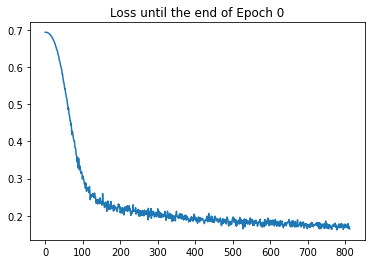

Epoch 2.
iter 200, loss 0.15415599942207336
iter 400, loss 0.1420280784368515
iter 600, loss 0.1340135633945465
iter 800, loss 0.12631815671920776
epoch: 1, loss: 0.0000, time: 1081.42


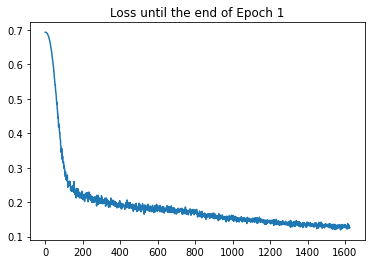

In [18]:
model = None

def main():
    global model

    model = IP2Vec(vocab_size,embedding_dim=128, word_to_ind=word_to_ind)
    trainer = SGNSTrainer(pairs = pairs, model = model, word_to_ind = word_to_ind, batch_size = 2**9, ns_table = ns_table, n_epochs = 2, k = 20)
    
    trainer.train()

main()


In [19]:
model.get_ip_embeddings('24.251.45.232')


tensor([[ 3.6288e-03,  4.2481e-04,  7.4446e-04,  1.0061e-03, -2.2955e-03,
         -3.7387e-03, -2.2634e-03,  3.2091e-03,  2.3584e-03,  2.1584e-03,
          3.5268e-03,  7.7240e-04, -3.2760e-03, -2.1235e-03,  3.5935e-03,
          3.0345e-03,  3.2488e-03,  2.3015e-03, -5.9649e-04, -1.2279e-03,
         -3.7073e-03, -2.1068e-04,  2.8173e-03,  2.0193e-03,  1.9791e-03,
          8.6873e-04,  1.2119e-03, -1.9423e-03, -2.9486e-03, -5.0157e-04,
          1.6001e-03, -3.0591e-03, -2.6715e-03,  2.4930e-03, -2.4265e-03,
          2.0759e-04, -2.0403e-03,  8.3317e-04, -3.6936e-03, -8.4493e-04,
          1.2296e-03, -1.4259e-03, -1.8743e-04, -8.0446e-04,  1.2302e-03,
         -2.6887e-03, -1.0998e-03, -1.1958e-03, -1.1340e-03,  1.0223e-03,
          6.1883e-04,  1.5530e-03, -1.4592e-03,  2.3770e-04,  2.9960e-03,
          3.6418e-03,  2.5965e-03,  3.3470e-04,  7.6952e-04,  7.2036e-04,
         -1.0445e-03, -2.8167e-03,  2.7182e-03,  3.1318e-03, -3.8356e-03,
          1.7991e-03, -1.7574e-03, -6.

In [20]:
model.get_ip_embeddings('109.66.135.125')
# model.get_ip_embeddings('36982')


tensor([[-0.0700, -0.0678,  0.0666,  0.0672,  0.0698,  0.0715,  0.0712,  0.0722,
         -0.0657,  0.0685,  0.0659, -0.0702, -0.0677,  0.0686, -0.0700, -0.0667,
         -0.0656,  0.0694, -0.0671,  0.0665,  0.0652,  0.0661,  0.0693,  0.0664,
         -0.0689,  0.0650, -0.0665, -0.0676,  0.0674, -0.0658,  0.0685, -0.0657,
          0.0679, -0.0692, -0.0697,  0.0686,  0.0701,  0.0682, -0.0655,  0.0706,
          0.0670, -0.0686, -0.0646,  0.0709,  0.0685,  0.0698, -0.0645,  0.0671,
         -0.0637, -0.0649, -0.0680,  0.0670, -0.0706,  0.0676,  0.0672, -0.0683,
         -0.0716,  0.0659,  0.0647, -0.0722,  0.0637, -0.0721, -0.0712, -0.0641,
          0.0677,  0.0662,  0.0664, -0.0686,  0.0655, -0.0649, -0.0696, -0.0692,
         -0.0700, -0.0660, -0.0642, -0.0695,  0.0663,  0.0716, -0.0672,  0.0663,
         -0.0643, -0.0720,  0.0675, -0.0665,  0.0650,  0.0710, -0.0718, -0.0704,
          0.0653,  0.0683,  0.0679, -0.0710, -0.0653, -0.0664, -0.0658, -0.0685,
          0.0676,  0.0705, -

# t-SNE
`tSNE` allows us to project high dimentional embeddings onto lower dimentions, while preserving distances. That makes the `t-SNE` a powertfull tool as it allows us to test how distinct our embeddings. In `Word2Vec` two words will have a similar embeddings if they tend to appear in similar contexts. In our case, IP addresses will have similar embeddings if they send traffic to similar locations. `t-SNA` takes the normalized vector so we first normalize them, then we change the `perplexity` parameter, that defines how many neighbors should be included in 1 standard deviation in a gaussian who's average is the point we are looking at each time. For more information about `t-SNE` see [this](https://www.youtube.com/watch?v=MnRskV3NY1k&ab_channel=T%C3%BCbingenMachineLearning) presentation and [this](https://distill.pub/2016/misread-tsne/) article.  
Results show that even after playing with different values for `perplexity`, it seems that a subsample of entities got a distinctively different embeddings' values, while the rest were clustered together in a giant cloud. One reason for that is organic. In that case, the data describe traffice between two main networks, one is large (and hence the large cloud of points), the other is smaller. IP addresses from those two groups have small tendency to appear together, while in each group they appear together again and again. A second exlenation for these results is less comfurting. In this explenation, the giant cloud is resulting from low number of observations, so the embeddings haven't moved so far from their initial values.

(20472, 128)
Example of normalized embeddings:
[[ 0.13331725 -0.04424932 -0.05084587  0.05598853 -0.07386814 -0.01834406
   0.00032433  0.11877318 -0.00772842  0.0104785   0.02279551 -0.11802933
  -0.10087359 -0.10665812  0.02402473 -0.07408499  0.10316958 -0.15156011
   0.092866    0.03598131  0.14407785 -0.03101496  0.13439545  0.09424034
   0.11172264 -0.09976584  0.05727379 -0.03441495  0.05452615 -0.10619031
   0.15073523  0.05156993 -0.04899276  0.00111436  0.00363722  0.11491631
  -0.10068344 -0.1436286   0.12844652  0.03747017 -0.01469122  0.08308484
   0.05469527 -0.037278   -0.02932701  0.13444008  0.0589963  -0.12135829
   0.01987013 -0.02921149 -0.06163943 -0.09734007  0.10700258 -0.08055906
   0.14550829  0.05647655 -0.09800148 -0.05283208  0.06877644 -0.08278935
   0.09752644 -0.08756823  0.13855198  0.05669747 -0.05449319 -0.08787786
   0.14284287  0.14113307 -0.14381164  0.05798692 -0.08452989 -0.00755227
   0.11674514  0.12715524 -0.03851837  0.01390668  0.02527453 -0.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


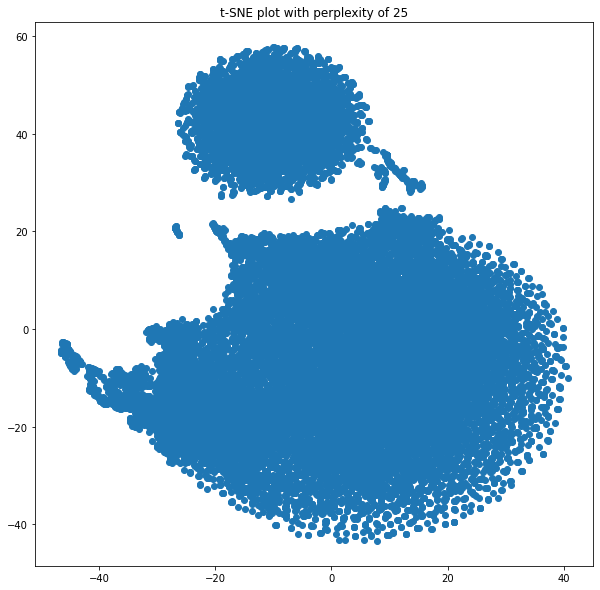

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


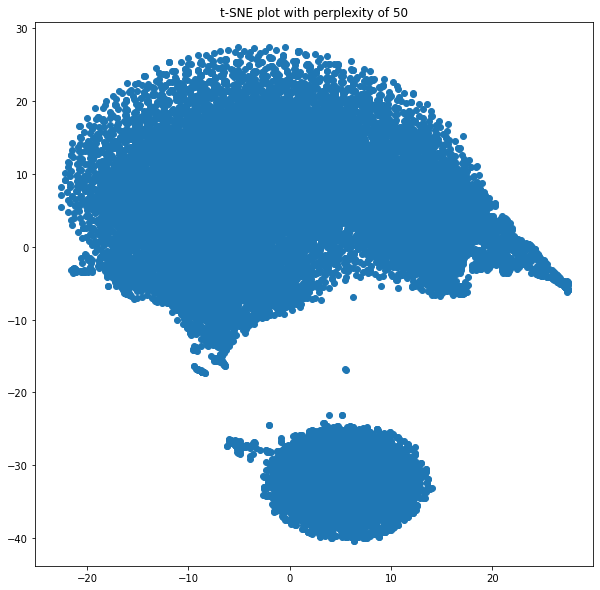

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


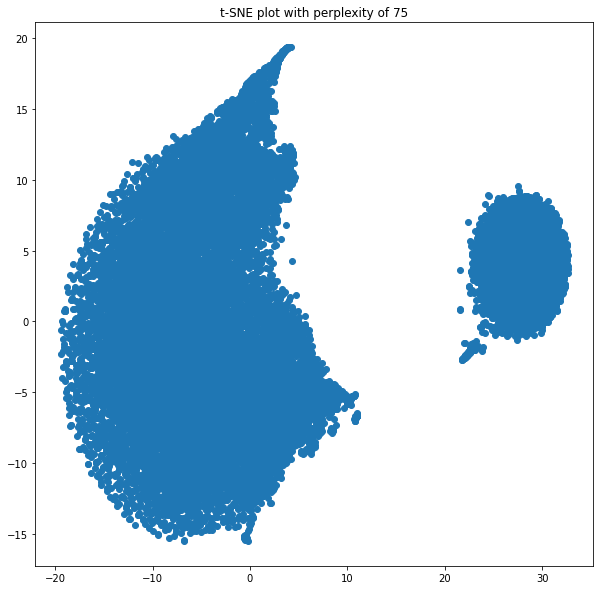

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


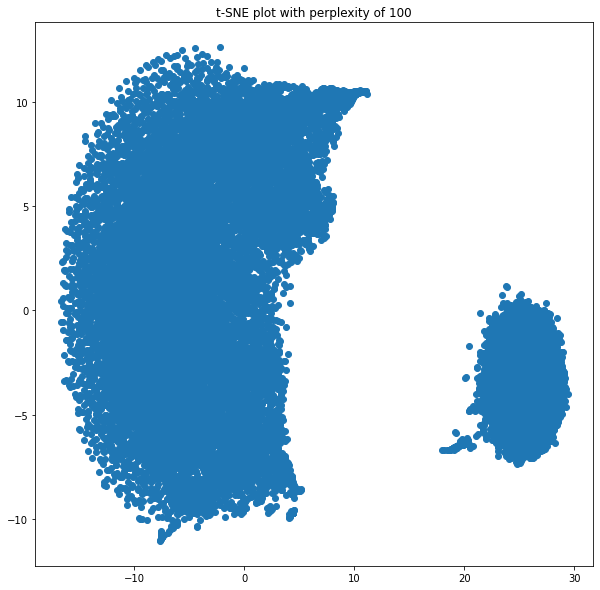

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


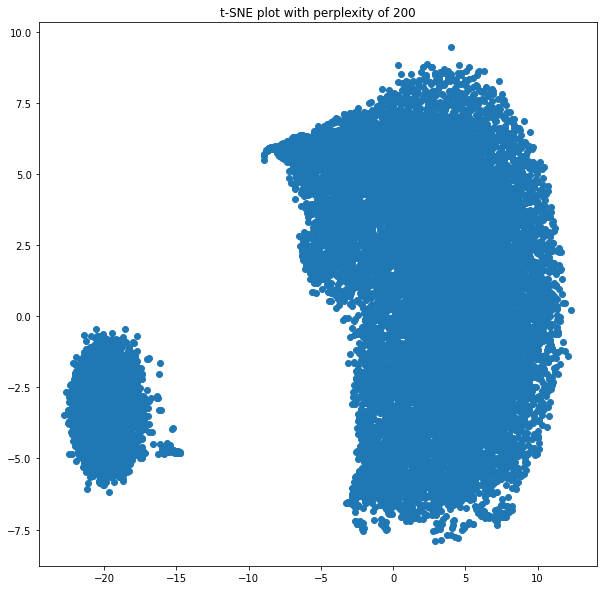

In [41]:
from sklearn.manifold import TSNE
from sklearn import preprocessing

def get_embeddings(ip): 
  s = model.get_ip_embeddings(ip)
  return preprocessing.normalize(s.cpu().detach().numpy(), norm='l2')

entities = [x[0] for x in ns_table]

vectors_of_embeddings = np.array([get_embeddings(x) for x in entities]).reshape(len(entities), 128)
print(vectors_of_embeddings.shape)

print('Example of normalized embeddings:')
print(get_embeddings(entities[7]))

for perplexity_ in [25,50,75,100,200]:
  tsne_x = TSNE(n_components=2, perplexity=perplexity_).fit_transform(vectors_of_embeddings)
  plt.figure(figsize=(10,10))
  plt.scatter(tsne_x[:,0], tsne_x[:,1])
  plt.title(f't-SNE plot with perplexity of {perplexity_}')
  plt.show()